In [1]:
from __future__ import print_function
%matplotlib inline

In [2]:
import os, h5py
from skimage.transform import resize
from skimage.io import imsave, imshow
from skimage.exposure import equalize_adapthist

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [19]:
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model

import tensorflow as tf

def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))
            
        return Model(input=model.inputs, output=merged)

In [3]:
FolderPath = "../../dataset/ultrasound_nerve_segmentation/"

K.set_image_dim_ordering('tf')
#K.set_floatx('float16')

#original size : 420x580
img_rows=96
img_cols=96

f_size = 1
learning_rate = 1e-2
activation = 'elu'

smooth = 1.


In [4]:
def load_train_data():
    with h5py.File(FolderPath + 'X_Train.h5', 'r') as hf:
        imgs_train = hf['X_Train'][:]
    with h5py.File(FolderPath + 'Y_Train.h5', 'r') as hf:
        imgs_mask_train = hf['Y_Train'][:]
    
    return imgs_train, imgs_mask_train


# In[6]:

def load_test_data():
    with h5py.File(FolderPath + 'X_Test.h5', 'r') as hf:
        imgs_test = hf['X_Test'][:]
    with h5py.File(FolderPath + 'Y_Test.h5', 'r') as hf:
        imgs_mask_test = hf['Y_Test'][:]
        
    return imgs_test, imgs_mask_test

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [32]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Convolution2D(3, 1, 1, activation=activation, border_mode='same')(inputs)

    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model = make_parallel(model, 2)
    model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()
    
    
    return model

In [12]:
def exposure_image(X):
    Xf = np.array(X)
    for i in range(X.shape[0]):
        Xf[i] = equalize_adapthist(X[i])
    return Xf

def preprocess(X,y):
    X = (X / 255.).astype(np.float32)
    y = (y / 255.).astype(np.float32)

    X = exposure_image(X)
    
    return X,y

In [13]:
def resize_image(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [33]:
model = get_unet()
model_checkpoint = ModelCheckpoint('model_UNET.hdf5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 1), activation="elu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="elu", padding="same")`
  """
/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="elu", padding="same")`
  
/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Co

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 96, 96, 1)     0                                            
____________________________________________________________________________________________________
lambda_9 (Lambda)                (None, 96, 96, 1)     0           input_5[0][0]                    
____________________________________________________________________________________________________
lambda_10 (Lambda)               (None, 96, 96, 1)     0           input_5[0][0]                    
____________________________________________________________________________________________________
model_6 (Model)                  (None, 96, 96, 1)     7852551     lambda_9[0][0]                   
                                                                   lambda_10[0][0]         

/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [14]:
imgs_train, imgs_mask_train = load_train_data()

In [15]:
imgs_train, imgs_mask_train = preprocess(imgs_train, imgs_mask_train)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [16]:
imgs_train = resize_image(imgs_train)
imgs_mask_train = resize_image(imgs_mask_train)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [34]:
imgs_train.shape, imgs_mask_train.shape

((9016, 96, 96, 1), (9016, 96, 96, 1))

In [35]:
model.fit(imgs_train, imgs_mask_train, batch_size=128*2, nb_epoch=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, model_earlystopping])

/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 7212 samples, validate on 1804 samples
Epoch 1/20
7212/7212 [==============================] - 58s - loss: -0.0664 - dice_coef: 0.0664 - val_loss: -0.0245 - val_dice_coef: 0.0245
Epoch 2/20
7212/7212 [==============================] - 47s - loss: -0.2500 - dice_coef: 0.2500 - val_loss: -0.0012 - val_dice_coef: 0.0012
Epoch 3/20
7212/7212 [==============================] - 48s - loss: -0.3407 - dice_coef: 0.3407 - val_loss: -0.0509 - val_dice_coef: 0.0509
Epoch 4/20
7212/7212 [==============================] - 47s - loss: -0.3732 - dice_coef: 0.3732 - val_loss: -0.0668 - val_dice_coef: 0.0668
Epoch 5/20
7212/7212 [==============================] - 47s - loss: -0.3955 - dice_coef: 0.3955 - val_loss: -1.8330e-04 - val_dice_coef: 1.8330e-04
Epoch 6/20
7212/7212 [==============================] - 48s - loss: -0.4084 - dice_coef: 0.4084 - val_loss: -4.3144e-05 - val_dice_coef: 4.3144e-05
Epoch 7/20
7212/7212 [==============================] - 48s - loss: -0.4182 - dice_coef: 0.4182 

In [36]:
imgs_test, imgs_id_test = load_test_data()

In [37]:
imgs_test, imgs_id_test = preprocess(imgs_test, imgs_id_test)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [38]:
imgs_test = resize_image(imgs_test)
imgs_id_test = resize_image(imgs_id_test)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [39]:
model.load_weights('model_UNET.hdf5')

In [40]:
loss, accu = model.evaluate(imgs_test, imgs_id_test, verbose=1)
print("loss:{}%, accuracy:{}%".format(loss*100, accu*100))

2254/2254 [==============================] - 7s     
loss:-36.13164783476091%, accuracy:36.13164782550553%


In [41]:
imgs_pred_test = model.predict(imgs_test, verbose=1)

2240/2254 [============================>.] - ETA: 0s

In [42]:
pred_dir = 'preds'
test_dir = 'tests'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [36]:
# for image_id, image in enumerate(imgs_pred_test):
#     image = (image[:,:,0] * 255.).astype(np.uint8)
#     imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

In [43]:
imgs_test.shape

(2254, 96, 96, 1)

In [44]:
def plot_compare(idx):
    plt.figure(dpi=40)
    plt.subplot(131)
    imshow(imgs_id_test[idx,:,:,0],cmap='gray')
    plt.subplot(132)
    imshow(imgs_test[idx,:,:,0],cmap='gray')
    imshow(imgs_pred_test[idx,:,:,0],cmap='jet', alpha=0.5)
    plt.subplot(133)
    imshow(imgs_id_test[idx,:,:,0] - imgs_pred_test[idx,:,:,0], cmap='gray')
    plt.savefig(os.path.join(test_dir, 'test' + str(idx) + '.png'))

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


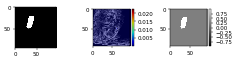

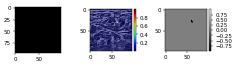

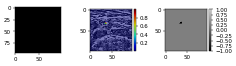

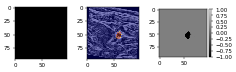

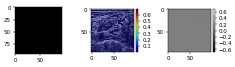

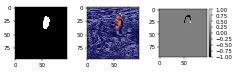

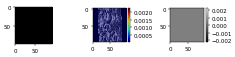

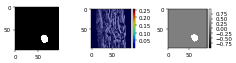

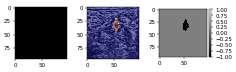

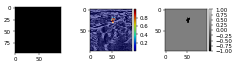

In [45]:
ran_idx = np.random.randint(0, imgs_test.shape[0],10)
for i,idx in enumerate(ran_idx):
    plot_compare(idx)